In [3]:
# Connecting to Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!export LC_ALL=en_US.UTF-8


In [5]:
# Installing libraries
!pip install sentencepiece
!pip install transformers datasets
!pip install torch huggingface_hub 
!pip install rouge.score nltk py7zr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 22.6 MB/s eta 0:00:00


In [6]:
# Importing the required libraries
import torch
import numpy as np
import pandas as pd
import datasets
import transformers
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:

# Specifying parameters

LR_MIN = 3e-5
LR_CEIL = 0.01
WD_MIN = 2e-5
WD_CEIL = 0.01
MIN_EPOCHS = 6
MAX_EPOCHS = 12
MIN_BATCH_SIZE = 4
MAX_BATCH_SIZE = 6
NUM_TRIALS = 1
WARMUP_RATIO_MIN = 0.05
WARMUP_RATIO_MAX = 0.1
SAVE_DIR = 'opt-test'
MODEL_NAME = 't5-base'
MAX_INPUT = 512
MAX_TARGET = 250

# Selecting the first 2000 rows
dataset_path = 'gdrive/My Drive/fyp/'
data = pd.read_csv(dataset_path + 'xsum.csv', encoding='latin-1')
data = data[0:2000]

metric = datasets.load_metric('rouge')
data

def print_custom(text):
    print('\n')
    print(text)
    print('-'*100)

<ipython-input-7-da5824576295>:24: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric('rouge')


In [8]:
# Loading tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
# Preprocessin data
prefix = "summarize: "
def preprocess_data(data_to_process):
    #retrive document text
    
    inputs = [prefix + doc for doc in data_to_process["document"]]
  
    #tokenize text
    model_inputs = tokenizer(inputs,  max_length=MAX_INPUT, padding='max_length', truncation=True)

    #tokenize labels
    with tokenizer.as_target_tokenizer():
        targets = tokenizer(data_to_process['summary'], max_length=MAX_TARGET, padding='max_length', truncation=True)
        
    model_inputs['labels'] = targets['input_ids']
    return model_inputs

In [ ]:
#  Perform a train test split of 80:20 ratio on the dataset
train_dataset = data[:int(len(data)*0.7)]
test_dataset = data[int(len(data)*0.7):int(len(data)*0.85)]
validation_dataset = data[int(len(data)*0.85):]

# Creating the dataset dictionary
data = datasets.DatasetDict({ 'train': datasets.Dataset.from_pandas(train_dataset), 
                              'test': datasets.Dataset.from_pandas(test_dataset),
                              'validation': datasets.Dataset.from_pandas(train_dataset)})

In [ ]:
# Preprocessing data
tokenize_data = data.map(preprocess_data, batched = True, remove_columns=['document', 'summary'])

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

In [ ]:
#sample the data
train_sample = tokenize_data['train'].shuffle(seed=123).select(range(1000))
validation_sample = tokenize_data['validation'].shuffle(seed=123).select(range(300))
test_sample = tokenize_data['test'].shuffle(seed=123).select(range(200))
     
# Updating tokenize_data dictionary
tokenize_data['train'] = train_sample
tokenize_data['validation'] = validation_sample
tokenize_data['test'] = test_sample

tokenize_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 300
    })
})

In [9]:
#loading the model
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

batch_size = 1

#data_collator to create batches
data_collator = transformers.DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
def compute_rouge(pred):
    predictions, labels = pred
    # Decode the predictions
    decode_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Decode labels
    decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute results
    res = metric.compute(predictions=decode_predictions, references=decode_labels, use_stemmer=True)
    res = {key: value.mid.fmeasure * 100 for key, value in res.items()}

    # Define weights for each ROUGE score
    weights = {'rouge1': 0.5, 'rouge2': 0.3, 'rougeL': 0.2}

    # Compute the weighted average of the rouge scores
    weighted_avg_rouge = sum(res[key] * weight for key, weight in weights.items()) / sum(weights.values())
    res['weighted_avg_rouge'] = round(weighted_avg_rouge, 4)

    # Compute the average length of generated summaries
    pred_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    res['avg_gen_len'] = np.mean(pred_lens)

    return {k: round(v, 4) for k, v in res.items()}


In [ ]:
# Creating training arguments
args = transformers.Seq2SeqTrainingArguments(
    'generic-summary',
    evaluation_strategy='epoch',
    learning_rate=0.001,
    per_device_train_batch_size=1, 
    per_device_eval_batch_size= 1, 
    gradient_accumulation_steps=2,
    weight_decay=0.1,
    save_total_limit=2,
    warmup_ratio=0.1,
    num_train_epochs=7,
    predict_with_generate=True,
    eval_accumulation_steps=1,
    fp16=True
  )

# Create the trainer
trainer = transformers.Seq2SeqTrainer(
    model, 
    args,
    train_dataset=tokenize_data['train'],
    eval_dataset=tokenize_data['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge
)


In [ ]:
# Clearing the cuda memory
import torch
torch.cuda.empty_cache()

In [ ]:

# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Weighted Avg Rouge,Avg Gen Len
1,0.912300,0.230005,29.929600,9.988200,24.532400,24.508400,22.867700,18.586700
2,0.274800,0.143818,38.207700,19.331200,33.240900,33.190000,31.551400,18.590000
3,0.177300,0.074992,47.517100,32.558000,43.385700,43.212400,42.203100,18.786700
4,0.107200,0.037700,58.975500,48.388500,56.138700,56.202200,55.232000,18.763300
5,0.055100,0.013345,75.424500,71.583600,74.698000,74.727100,74.126900,18.773300
6,0.026600,0.004745,79.594000,78.191200,79.630000,79.568900,79.180300,18.790000
7,0.013100,0.002626,80.150500,78.929800,80.113700,80.090800,79.776900,18.776700


TrainOutput(global_step=3500, training_loss=0.22375908075060164, metrics={'train_runtime': 2104.3589, 'train_samples_per_second': 3.326, 'train_steps_per_second': 1.663, 'total_flos': 4262705233920000.0, 'train_loss': 0.22375908075060164, 'epoch': 7.0})

In [ ]:
# Clearing the cuda memory
torch.cuda.empty_cache()

In [ ]:
# Evaluate the model
metrics = trainer.evaluate()



Printing the metrics
----------------------------------------------------------------------------------------------------
{'eval_loss': 0.0026263988111168146, 'eval_rouge1': 80.1505, 'eval_rouge2': 78.9298, 'eval_rougeL': 80.1137, 'eval_rougeLsum': 80.0908, 'eval_weighted_avg_rouge': 79.7769, 'eval_avg_gen_len': 18.7767, 'eval_runtime': 117.1934, 'eval_samples_per_second': 2.56, 'eval_steps_per_second': 2.56, 'epoch': 7.0}


ROUGE Scores by Epoch for Text Summarization
----------------------------------------------------------------------------------------------------


<Axes: xlabel='epoch'>

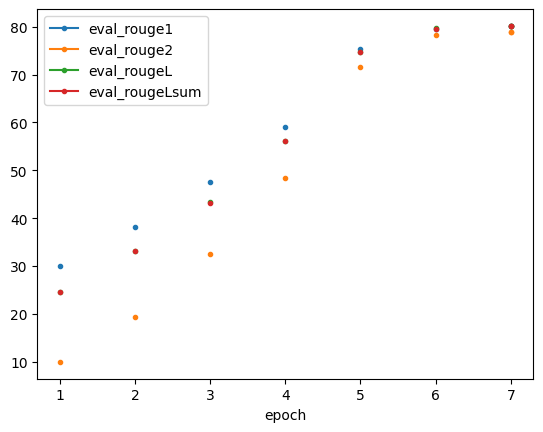

In [ ]:
# Print the metrics
print_custom('Printing the metrics')
print(metrics)

df = pd.DataFrame(trainer.state.log_history)

# Creating a line graph for the metrics
print_custom('ROUGE Scores by Epoch for Text Summarization')
df.plot(x='epoch', y=['eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum'], style='.-')



Validation Loss by Epoch for Text Summarization
----------------------------------------------------------------------------------------------------


<Axes: xlabel='epoch'>

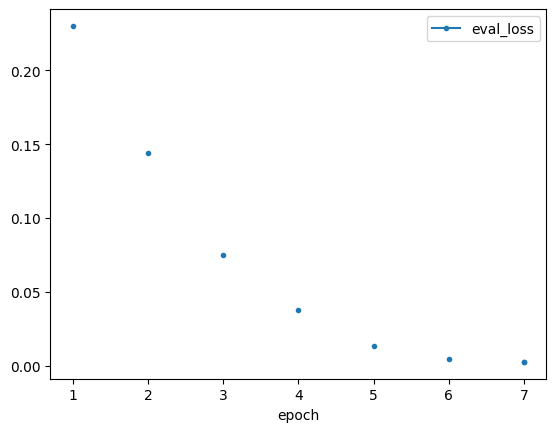

In [ ]:
# Creating the validation loss graph 
print_custom('Validation Loss by Epoch for Text Summarization')
df.plot(x='epoch', y=['eval_loss'], style='.-')

<Axes: title={'center': 'Evolution of ROUGE Scores and Weighted Average ROUGE by Epoch'}, xlabel='epoch'>

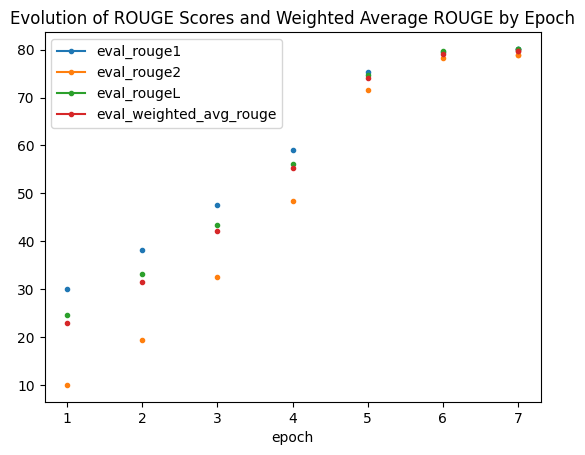

In [ ]:
df.plot(x='epoch', y=['eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_weighted_avg_rouge'], style='.-', title="Evolution of ROUGE Scores and Weighted Average ROUGE by Epoch")


<Axes: title={'center': 'Comparison of Training and Evaluation Losses by Epoch'}, xlabel='epoch'>

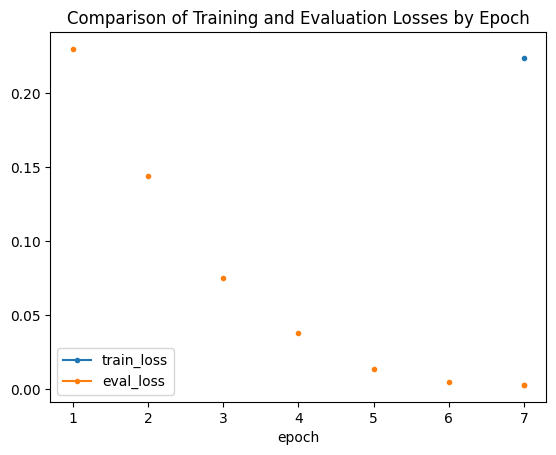

In [ ]:
df.plot(x='epoch', y=['train_loss', 'eval_loss'], style='.-', title="Comparison of Training and Evaluation Losses by Epoch")


<Axes: title={'center': 'Learning Rate Schedule by Training Step'}, xlabel='step'>

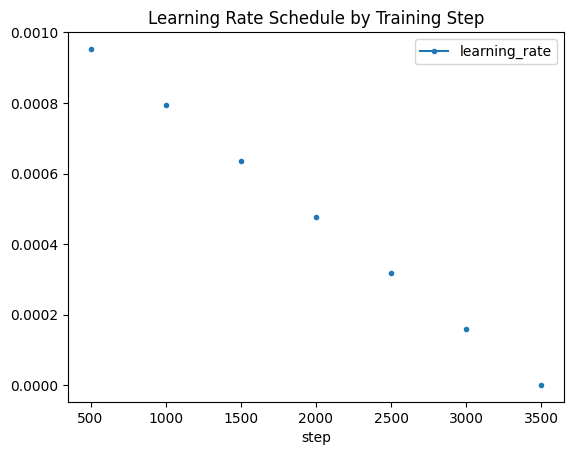

In [ ]:
df.plot(x='step', y=['learning_rate'], style='.-', title="Learning Rate Schedule by Training Step")


In [21]:
import os
import re

def capitalize_sentences(summary):
    # Capitalize the first letter of each sentence
    summary = re.sub(r'(?<=\.\s)(\w)', lambda x: x.group(1).upper(), summary)

    # Remove any leading punctuation or whitespace
    summary = re.sub(r'^[^a-zA-Z]*', '', summary)

    # Ensure the first character is uppercase
    summary = summary[0].upper() + summary[1:]

    return summary

document = """The UK is set to review the artificial intelligence (AI) market to make sure its benefits are available for everyone and that no single firm will dominate.

The investigation by the competition watchdog will look at the software behind chatbots like ChatGPT.

The industry is facing scrutiny over the pace at which it is developing technology to mimic human behaviour.

AI's rapid take-up has sparked fears of job losses, privacy and the potential to circulate misleading information.

ADVERTISEMENT

Sarah Cardell, chief executive of the Competition and Markets Authority (CMA), said so-called foundation models such as the software behind ChatGPT had the potential to "transform the way businesses compete as well as drive substantial economic growth".

But she said it was crucial that the potential benefits were "readily accessible to UK businesses and consumers while people remain protected from issues like false or misleading information".

The move comes days after Geoffrey Hinton - a man widely seen as the godfather of artificial intelligence - quit his job, warning about the growing dangers from developments in the field, which enables technology to create images or text that are barely distinguishable from the work of humans.

Sir Martin Sorrell, founder of the advertising companies WPP and S4, told the BBC that AI would be an "industrial revolution" and "another major shift in technology , rivalling, maybe even more significant than the iPhone and similar developments".

The digital advertising industry is already seeing the impact, he added, with firms using AI to "hyper personalise" ads for consumers.

"Obviously that raises all sorts of issues around regulation as well," Sir Martin told the Today programme.

He added that currently two companies dominate the AI space - Microsoft, which owns ChatGPT, and Google which has launched a rival chatbot called Bard.

Sir Martin said the CMA had shown its willingness to stop tech firms having too much power, for example by blocking Microsoft's planned takeover of UK gaming giant Activision Blizzard last week which sparked a furious reaction from the tech giant.

The US competition watchdog, the Federal Trade Commission, has also called for tougher regulation of AI.

"The [UK's] regulator is saying bigger is bad," Sir Martin said. "But the cost of developing [AI] technologies is so huge and thereby hangs the dilemma... If you restrict it you will restrict progress."

Some have warned that tools such as Bard and ChatGPT - which can write essays, do computer coding and even have conversations in a human-like way - could end up displacing hundreds of millions of jobs.

Mr Hinton told the BBC that some of the dangers of AI chatbots were "quite scary", and that they could soon overtake the level of information that a human brain holds.

"Right now, they're not more intelligent than us, as far as I can tell. But I think they soon may be."

In March, key figures in artificial intelligence called for powerful AI systems to halted for at least six months amid concerns about the threats they posed.

Twitter chief Elon Musk and Apple co-founder Steve Wozniak were among those to sign an open letter warning of the risks, and say the race to develop AI systems is out of control.

The CMA said the development of AI had raised several other issues, including safety; security; privacy; intellectual property and copyright; and human rights.

The watchdog said it would specifically be looking at the impact on competition, with a view to creating a set of "guiding principles" to protect consumers as AI develops.

The heads of Google, Microsoft, OpenAI and Anthropic are due to meet US Vice President Kamala Harris to discuss issues surrounding AI on Thursday.

Reuters reported that the invitation to the companies included President Joe Biden's "expectation that companies like yours must make sure their products are safe before making them available to the public".

"""

inputs = tokenizer.encode(document, return_tensors='pt', max_length=MAX_INPUT, truncation=True)

# Ensure both model and inputs are on the same device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = inputs.to(device)

outputs = model.generate(inputs, max_length=500, min_length=75, length_penalty=1.5, num_beams=5, early_stopping=True, no_repeat_ngram_size=2)
summary = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Capitalize the sentences in the summary
summary = capitalize_sentences(summary)

print("Generic summary")
print(summary)


Generic summary
Competition watchdog will look at the software behind chatbots like ChatGPT. The industry is facing scrutiny over the pace at which it is developing technology to mimic human behaviour. It has sparked fears of job losses, privacy and the potential to circulate misleading information. Sir Martin Sorrell, founder of the advertising companies WPP and S4, told the BBC that AI would be an "industrial revolution" and "another major shift in technology, perhaps even more significant than the iPhone and similar developments".


In [22]:
# Save the model
drive_path_to_save_model = 'gdrive/My Drive/fyp/GenericSummarizationModels/' + MODEL_NAME + '-model'

# Ensure the model directory exists, and create it if not
model_directory = os.path.dirname(drive_path_to_save_model)
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Save the model
model.save_pretrained(drive_path_to_save_model)

# Save the tokenizer
drive_path_to_save_tokenizer = 'gdrive/My Drive/fyp/GenericSummarizationModels/' + MODEL_NAME + '-tokenizer'

# Ensure the tokenizer directory exists, and create it if not
tokenizer_directory = os.path.dirname(drive_path_to_save_tokenizer)
if not os.path.exists(tokenizer_directory):
    os.makedirs(tokenizer_directory)

# Save the tokenizer
tokenizer.save_pretrained(drive_path_to_save_tokenizer)

# Load the model
drive_path_to_load_model = 'gdrive/My Drive/fyp/GenericSummarizationModels/' + MODEL_NAME + '-model'
loaded_model = transformers.AutoModelForSeq2SeqLM.from_pretrained(drive_path_to_load_model)

# Load the tokenizer
drive_path_to_load_tokenizer = 'gdrive/My Drive/fyp/GenericSummarizationModels/' + MODEL_NAME + '-tokenizer'
loaded_tokenizer = transformers.AutoTokenizer.from_pretrained(drive_path_to_load_tokenizer)